In [33]:
import torch
import torch.nn as nn

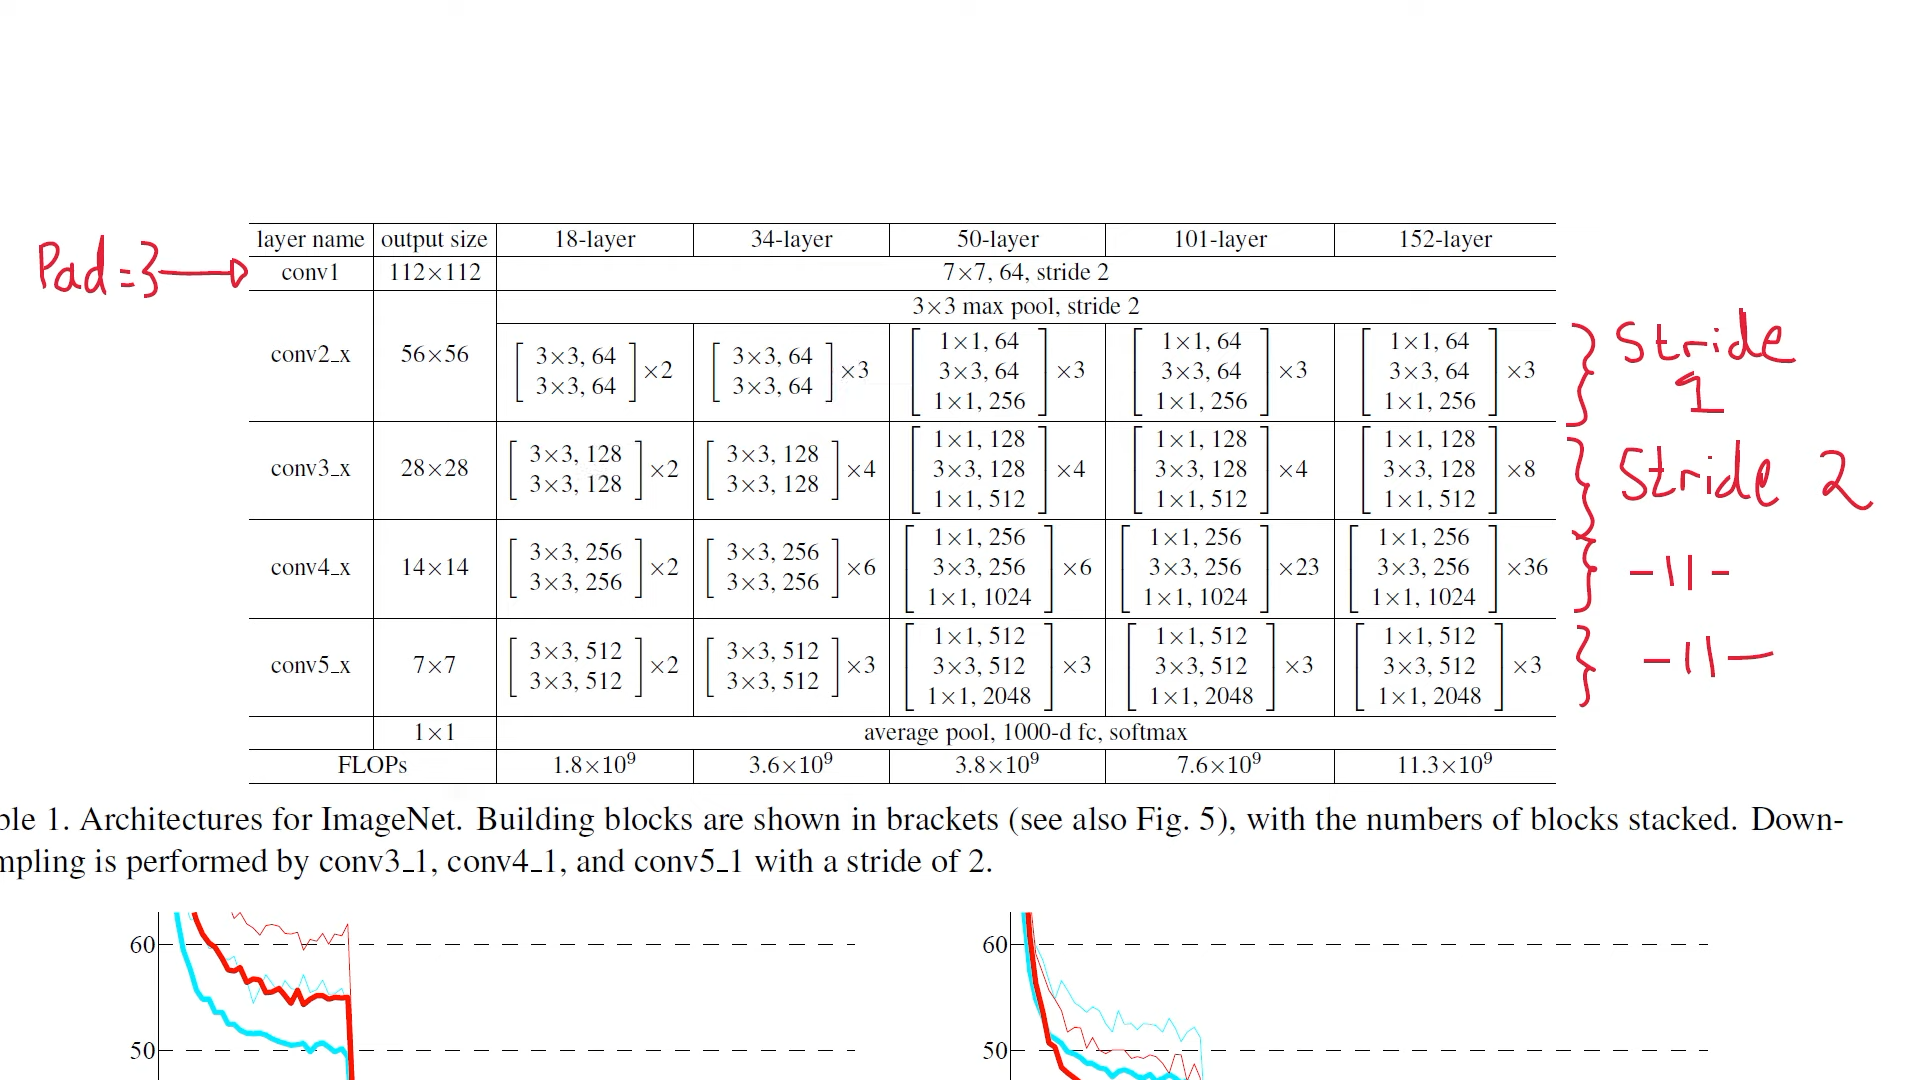

In [34]:
class Block(nn.Module):
    def __init__(self, in_channels, out_channels, 
                 identity_downsample=None, stride=1):
        super(Block, self).__init__()

        self.expansion = 4  # out 4x in as seen in the table

        self.conv1 = nn.Conv2d(in_channels, out_channels, kernel_size=1, 
                               stride=1, padding=0)
        self.bn1 = nn.BatchNorm2d(out_channels)

        self.conv2 = nn.Conv2d(in_channels, out_channels, kernel_size=3, 
                               stride=stride, padding=1)
        self.bn2 = nn.BatchNorm2d(out_channels)

        self.conv3 = nn.Conv2d(in_channels, out_channels*self.expansion, kernel_size=1, 
                               stride=1, padding=0)
        self.bn3 = nn.BatchNorm2d(out_channels*self.expansion)

        self.relu = nn.ReLU()

        self.identity_downsample = identity_downsample


    def forward(self, x):
        identity = x

        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu(x)

        x = self.conv3(x)
        x = self.bn3(x)
        
        if self.identity_downsample is not None:
            identity = self.identity_downsample(identity)
        
        x += identity
        x = self.relu(x)
        return x


In [35]:
class Resnet2D(nn.Module):  # [3, 4, 6, 3]
    def __init__(self, block: Block, layers, data_channels: int, output_size: int):
        """
            data_channels: it can be number of image channels or imu data chanenls
            output_size: it can be number of classes 
        """
        super(Resnet2D, self).__init__()
        self.in_channels = 64

        self.expansion = 4

        self.conv1 = nn.Conv2d(data_channels, self.in_channels, kernel_size=7, 
                               stride=2, padding=3)
        self.bn1 = nn.BatchNorm2d(self.in_channels)
        
        self.relu = nn.ReLU()
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding=1)

        # ResNet layers
        # self.layer1 = ...
        # self.layer2 = ...
        # We will write a function _make_layer to do this

        self.layer1 = self._make_layer(block=block,
                                       num_residual_blocks=layers[0],
                                       out_channels=64,
                                       stride=1
                                       )
        
        self.layer2 = self._make_layer(block=block,
                                       num_residual_blocks=layers[1],
                                       out_channels=128,
                                       stride=2
                                       )
        self.layer3 = self._make_layer(block=block,
                                       num_residual_blocks=layers[2],
                                       out_channels=256,
                                       stride=2
                                       )
        self.layer4 = self._make_layer(block=block,
                                       num_residual_blocks=layers[3],
                                       out_channels=512,
                                       stride=2
                                       )
        
        self.avgpool = nn.AdaptiveAvgPool2d((1,1))

        self.fc = nn.Linear(512*self.expansion, output_size)


    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu(x)
        x = self.maxpool(x)

        # Residual blocks
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.layer3(x)
        x = self.layer4(x)

        x = self.avgpool(x)
        x = x.reshape(x.shape[0], -1)

        x = self.fc(x)
        return x

    # def _make_layer(self, block: Block, num_residual_blocks: list, 
    #                 out_channels: int, stride: int):

    def _make_layer(self, block: Block, num_residual_blocks: int, 
                    out_channels: int, stride: int):
        
        identity_downsample = None
        layers = []

        if stride is not 1 or  self.in_channels is not out_channels*self.expansion:
            identity_downsample = nn.Sequential(
                                    nn.Conv2d(in_channels=self.in_channels, 
                                        out_channels=out_channels*self.expansion,
                                        kernel_size=1,
                                        stride=stride),
                                    nn.BatchNorm2d(out_channels*self.expansion)
                                )
        
        layers.append(block(in_channels=self.in_channels, 
                            out_channels=out_channels,
                            identity_downsample=identity_downsample,
                            stride=stride)
                    )
        # Updating in channels for next
        self.in_channels = out_channels*self.expansion

        # -1 because we already computed one residual block
        for i in range(num_residual_blocks - 1):
            layers.append(block(self.in_channels, out_channels))    #256 -> 64, 54*4(256) again

        return nn.Sequential(*layers)   # unpack list


In [36]:
def Resnet50(data_channels, output_size=1000):
    return Resnet2D(block=Block, 
                    layers=[3, 4, 6, 3],
                    data_channels=data_channels,
                    output_size=output_size)
    
def Resnet101(data_channels, output_size=1000):
    return Resnet2D(block=Block, 
                    layers=[3, 4, 23, 3],
                    data_channels=data_channels,
                    output_size=output_size)

def Resnet152(data_channels, output_size=1000):
    return Resnet2D(block=Block, 
                    layers=[3, 8, 36, 3],
                    data_channels=data_channels,
                    output_size=output_size)

## Now let's see if this works

In [37]:
def test():
    input_data = torch.randn(2, 3, 224, 244)    # 2 images of dims(224, 224, 3)
    data_channels = input_data.shape[1]
    
    net = Resnet50(data_channels=data_channels,
                   output_size=1000)
    y = net(input_data).to("cuda")

    print(y.shape)

In [38]:
test()

RuntimeError: ignored